In [1]:
import numpy as np
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# load data
path = '/kaggle/input/calabi-yau-cicy-4-folds'
conf = np.load(os.path.join(path, 'conf.npy'))
hodge = np.load(os.path.join(path, 'hodge.npy'))
direct = np.load(os.path.join(path, 'direct.npy'))
conf.shape, hodge.shape, direct.shape

((921497, 16, 20), (921497, 4), (921497,))

In [3]:
X = conf
h21 = hodge[:,1]
h22 = hodge[:,3]
h31 = hodge[:,2]

# Utility functions: Model, Train Loop, Accuracy

In [4]:
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
import sys
sys.path.append('/kaggle/input/calabi-yau-cicy-4-folds')
from CICY4_functions import data_generator, batch_gd,  calc_accuracy

In [7]:
from sklearn.model_selection import train_test_split
def train_test(X, y):
    X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, shuffle = True)
    
    X_train = torch.from_numpy(X_train.astype(np.float32))
    y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1))

    X_test = torch.from_numpy(X_test.astype(np.float32))
    y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1))
    
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

In [8]:
def plot_losses(train_losses, test_losses):
    # Plot the train loss and test loss per iteration
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test(X, h22)
train_gen = lambda: data_generator(X_train, y_train)
test_gen = lambda: data_generator(X_test, y_test)

torch.Size([737197, 16, 20]) torch.Size([737197, 1]) torch.Size([184300, 16, 20]) torch.Size([184300, 1])


# RNN Model for h22 with LSTM layers

In [10]:
class RNN_cicy4(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs, is_lstm=True):
        super(RNN_cicy4,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.is_lstm = is_lstm
        
        self.lstm = nn.LSTM(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)
        
        self.gru = nn.GRU(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)
        self.fc1 = nn.Linear(self.M, 128)
        self.fc2 = nn.Linear(128, self.K)
       
    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #get LSTM unit output:
        #output is NxTxM
        if self.is_lstm:
            out, _ = self.lstm(X, (h0,c0))
        else:
            out, _ = self.gru(X, h0)
        
        #we only want h(T) at the final time step
        out = out[:, -1, :]
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [11]:
# ( n_inputs, n_hidden, n_rnnlayers, n_outputs)
# n_inputs = D = # of columns: 20, T = 16
#input shape is NxTxD: Nx16x20
model1 = RNN_cicy4(20, 64, 3, 1 )
model1.to(device)

RNN_cicy4(
  (lstm): LSTM(20, 64, num_layers=3, batch_first=True)
  (gru): GRU(20, 64, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [12]:
#count the number of parameters in the model
params = [p.numel() for p in model1.parameters() if p.requires_grad]
#for item in params:
#    print(f'{item:>8}')
#print(f'________\n{sum(params):>8}')
print(params)
print(f'Total number of parameters is {sum(params)}')

[5120, 16384, 256, 256, 16384, 16384, 256, 256, 16384, 16384, 256, 256, 3840, 12288, 192, 192, 12288, 12288, 192, 192, 12288, 12288, 192, 192, 8192, 128, 128, 1]
Total number of parameters is 163457


## Shape tracing

In [13]:
X = X_train[0].to(device)
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')
print('Reshape the size to take in account the batch number')
X = X.view(1,16,20)
print(f'The new size is {X.shape}\n')

 #initial hidden states
h0 = torch.zeros(model1.L, X.size(0), model1.M).to(device)
c0 = torch.zeros(model1.L, X.size(0), model1.M).to(device)
print(f'Hidden states h0, c0: {h0.shape, c0.shape}')

X, _ = model1.lstm(X, (h0, c0))
print(f'Shape of the image after passing through the {model1.lstm}: \n {X.shape}\n')

X = model1.fc1(X)
print(f'Shape of the image after passing through the {model1.fc1}: \n {X.shape}\n')

X = model1.fc2(X)
print(f'Shape of the image after passing through the {model1.fc1}: \n {X.shape}\n')

Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 16, 20])

Hidden states h0, c0: (torch.Size([3, 1, 64]), torch.Size([3, 1, 64]))
Shape of the image after passing through the LSTM(20, 64, num_layers=3, batch_first=True): 
 torch.Size([1, 16, 64])

Shape of the image after passing through the Linear(in_features=64, out_features=128, bias=True): 
 torch.Size([1, 16, 128])

Shape of the image after passing through the Linear(in_features=64, out_features=128, bias=True): 
 torch.Size([1, 16, 1])



## Training loop

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters())

In [15]:
train_losses, test_losses=batch_gd(model1, criterion, optimizer,train_gen, test_gen, 80, device = device, cnn=False)

Epoch: 1/80, train loss:  4353.6701          test_loss:  3394.3689, duration: 0:00:18.505854
Epoch: 2/80, train loss:  3401.1026          test_loss:  3419.2619, duration: 0:00:17.978214
Epoch: 3/80, train loss:  3400.9504          test_loss:  3410.0336, duration: 0:00:17.904490
Epoch: 4/80, train loss:  3401.4491          test_loss:  3395.5761, duration: 0:00:18.147251
Epoch: 5/80, train loss:  3175.3711          test_loss:  2720.4834, duration: 0:00:18.048437
Epoch: 6/80, train loss:  2104.8231          test_loss:  1664.4761, duration: 0:00:17.868774
Epoch: 7/80, train loss:  1514.6066          test_loss:  1293.0851, duration: 0:00:17.954043
Epoch: 8/80, train loss:  1141.3075          test_loss:  898.0446, duration: 0:00:18.093684
Epoch: 9/80, train loss:  829.5378          test_loss:  682.4810, duration: 0:00:18.034457
Epoch: 10/80, train loss:  627.4464          test_loss:  611.9676, duration: 0:00:17.815050
Epoch: 11/80, train loss:  525.0511          test_loss:  476.3854, duratio

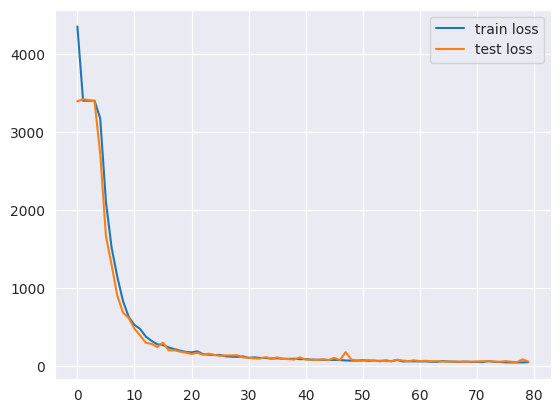

In [16]:
plot_losses(train_losses, test_losses)

In [17]:
train_acc, test_acc = calc_accuracy(model1, train_gen, test_gen, device = device, cnn= False)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.1009, Test acc: 0.0996


In [18]:
torch.save(model1, '/kaggle/working/saved_models/LSTM_cicy4_h22.pt')

# CNN Model for h22 

In [19]:
#same as CNN for h11
class CNN_cicy4(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,128, 4, 1)
        self.conv2 = nn.Conv2d(128,64, 3, 1)
        self.mxpool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.conv_total = nn.Sequential(
            self.conv1,
            self.mxpool,
            self.conv2,
            self.mxpool,
        )
        self.linear1 = nn.Linear(384,512)
        self.linear2 = nn.Linear(512,128)
        self.linear3 = nn.Linear(128,1)


    def forward(self,x):
        x = F.relu(self.conv_total(x))
        x = self.flat(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        
        return x


In [20]:
# ( n_inputs, n_hidden, n_rnnlayers, n_outputs)
# n_inputs = D = # of columns: 20, T = 16
#input shape is NxTxD: Nx16x20
model2 = CNN_cicy4()
model2.to(device)

CNN_cicy4(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (conv_total): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Linear(in_features=384, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=1, bias=True)
)

In [21]:
#count the number of parameters in the model
params = [p.numel() for p in model2.parameters() if p.requires_grad]
print(params)
print(f'Total number of parameters is {sum(params)}')

[2048, 128, 73728, 64, 196608, 512, 65536, 128, 128, 1]
Total number of parameters is 338881


In [22]:
X= X_train[0].to(device)
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')
print('Reshape the size to take in account the batch number')
X = X.view(1,1,16,20)
print(f'The new size is {X.shape}\n')

X = model2.conv_total(X)
print(f'Shape of the image after passing through {model2.conv_total}: \n {X.shape}\n')

X = model2.flat(X)
print(f'Shape of the image after passing through {model2.flat}: \n {X.shape}\n')

X = model2.linear1(X)
print(f'Shape of the image after passing through  {model2.linear1}: \n {X.shape}\n')

X = model2.linear2(X)
print(f'Shape of the image after passing through {model2.linear2}: \n {X.shape}\n')

X = model2.linear3(X)
print(f'Shape of the image after passing through {model2.linear3}: \n {X.shape}\n')

Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 1, 16, 20])

Shape of the image after passing through Sequential(
  (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
): 
 torch.Size([1, 64, 2, 3])

Shape of the image after passing through Flatten(start_dim=1, end_dim=-1): 
 torch.Size([1, 384])

Shape of the image after passing through  Linear(in_features=384, out_features=512, bias=True): 
 torch.Size([1, 512])

Shape of the image after passing through Linear(in_features=512, out_features=128, bias=True): 
 torch.Size([1, 128])

Shape of the image after passing through Linear(in_features=128, out_features=1, bias=True): 
 torch.Size([1, 1])

## Training Loop

In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters())

In [24]:
train_losses, test_losses=batch_gd(model2, criterion, optimizer,train_gen, test_gen, 80, device = device, cnn=True)

Epoch: 1/80, train loss:  2565.0293          test_loss:  2017.8555, duration: 0:00:17.321060
Epoch: 2/80, train loss:  1817.2849          test_loss:  1483.1138, duration: 0:00:16.824621
Epoch: 3/80, train loss:  1136.7165          test_loss:  884.4423, duration: 0:00:17.023267
Epoch: 4/80, train loss:  819.0422          test_loss:  767.8747, duration: 0:00:16.890808
Epoch: 5/80, train loss:  649.0496          test_loss:  563.8293, duration: 0:00:16.902751
Epoch: 6/80, train loss:  545.8984          test_loss:  519.5619, duration: 0:00:16.810793
Epoch: 7/80, train loss:  473.4822          test_loss:  447.7584, duration: 0:00:16.842631
Epoch: 8/80, train loss:  413.5579          test_loss:  398.2149, duration: 0:00:16.817073
Epoch: 9/80, train loss:  365.7753          test_loss:  359.3526, duration: 0:00:16.691536
Epoch: 10/80, train loss:  330.8578          test_loss:  331.2160, duration: 0:00:16.725822
Epoch: 11/80, train loss:  306.3070          test_loss:  327.6748, duration: 0:00:16

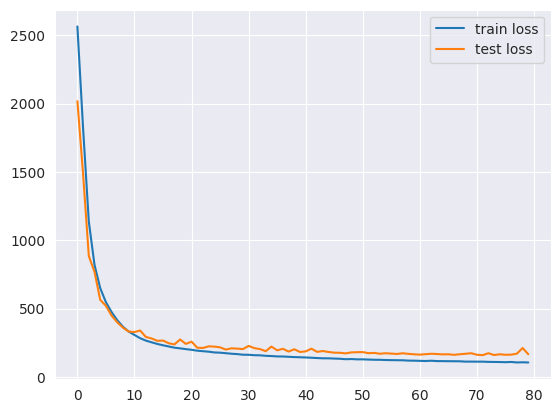

In [25]:
plot_losses(train_losses, test_losses)

In [26]:
train_acc, test_acc = calc_accuracy(model2, train_gen, test_gen, device = device, cnn= True)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.0583, Test acc: 0.0551


In [27]:
torch.save(model2, '/kaggle/working/saved_models/CNN_cicy4_h22.pt')